In [15]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Test GPU usage
if tf.config.list_physical_devices('GPU'):
    print("✓ GPU detected and available")
    with tf.device('/GPU:0'):
        a = tf.constant([1.0, 2.0, 3.0])
        b = tf.constant([4.0, 5.0, 6.0])
        c = tf.add(a, b)
        print(f"GPU computation result: {c}")
else:
    print("❌ No GPU available - using CPU")

TensorFlow version: 2.10.1
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ GPU detected and available
GPU computation result: [5. 7. 9.]


## Housekeeping Matters 

In [16]:
'''
This ipynb file is adapted from the previous ResNet training script
Author: Jason Niow
DtaeL 
'''

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pathlib

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

# paths to load datasets from
train_store_path = 'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/train_datasets/train_jul30_ood'
test_store_path = 'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/Data/test_datasets/test_jul22_real'

# convert to pathlib Path objects
train_dir = pathlib.Path(train_store_path)
test_dir = pathlib.Path(test_store_path)

# get list of datasets paths in dir
train_ds_paths = sorted(list(train_dir.glob('*.csv')))
test_ds_paths = sorted(list(test_dir.glob('*.csv')))


# extract classification target from file names
train_ds_type = np.array([x.parts[-1].split('_')[:2] for x in train_ds_paths])
test_ds_type = np.array([x.parts[-1].split('_')[:2] for x in test_ds_paths])

# Get list of classification labels of dataset e.g. 8CPSK, FM, 16qam
train_ds_mod = [s.upper() for s in train_ds_type[:,0]]
test_ds_mod = [s.upper() for s in test_ds_type[:,0]]

# Get list of classification frequency
train_ds_freq = [s.upper() for s in train_ds_type[:, 1]]
test_ds_freq = [s.upper() for s in test_ds_type[:, 1]]

# generate signal type tags
known_signal_tags = {'16QAM', '8CPSK', 'FM'}
signal_tags = {'16QAM': 0, '8CPSK': 1, 'FM': 2}
# signal_tags = {k : i for i, k in enumerate(np.unique(sorted([s.upper() for s in train_ds_mod] + ['UNKNOWN'])))}

print(signal_tags)


tensorflow version: 2.10.1
pandas version: 2.0.3
numpy version: 1.25.1
seaborn version: 0.13.2
GPU present
{'16QAM': 0, '8CPSK': 1, 'FM': 2}


## RMS Normalization (with optional DC offset correction)

In [17]:
import numpy as np

def rms_normalize(iq, target_rms=1.0, eps=1e-12, remove_dc=True):
    """
    iq: complex64/complex128 numpy array, shape (N,)
    target_rms: desired RMS after scaling
    """
    x = iq.astype(np.complex64, copy=False)
    if remove_dc:
        x = x - x.mean()
    rms = np.sqrt(np.mean(np.abs(x)**2) + eps)
    return x * (target_rms / rms)

## Loading Data

In [19]:

# load the dataset(s)

# load dataset information
specs = []
datasets = []

for dataset_paths in [train_ds_paths, test_ds_paths]:
    temp_ds = []
    temp_specs = []

    for path in dataset_paths:
        print(f'loading {path}...', end=' ')

        # load dataset details - Sampling frequency, Number of Samples, Number of Records
        df_spec = pd.read_csv(path, nrows=10, header=None, index_col=0, names=['info'])
        df_spec = df_spec.drop(['Version', 'DateTime', 'TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'], axis=0).astype('int')

        temp_specs.append(df_spec)

        # load data, strip unnecessary bits out - I/Q data
        df = pd.read_csv(path, skiprows=10, names=['I', 'Q'])

        df = df.loc[~df['I'].isin(['TimestampOffset', 'TriggerPosition', 'FastFrameID', 'IDInFastFrame', 'TotalInFastFrame'])]
        df['I'] = df['I'].astype('float')

        print(f'loaded')

        temp_ds.append(df)

    datasets.append(temp_ds)
    specs.append(temp_specs)

print('done.')
        


loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul30_ood\16qam_f237M_bnet_test-2024.08.19.12.41.56.619_chunk_1.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul30_ood\16qam_f237M_bnet_test-2024.08.19.12.42.02.745_chunk_1.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul30_ood\16qam_f237M_bnet_test-2024.08.19.12.42.12.097_chunk_1.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul30_ood\16qam_f237M_bnet_test-2024.08.19.12.42.15.700_chunk_1.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul30_ood\16qam_f237M_bnet_test-2024.08.19.12.42.16.958_chunk_1.csv... loaded
loading C:\Users\UserAdmin\Desktop\Jason - Signal Classification\AI Models\Data\train_datasets\train_jul3

In [20]:
# len(specs[0]), len(specs[1])
len(datasets[0]), len(datasets[1])

(11830, 1020)

# Processing Data

In [21]:

# split dataset(s) into records, extract test dataset
processed = []

# number of test records to extract
ntest = 100
rlength = 1024
nrecords = 1
nsamples = 10000

for h, dataset in enumerate(datasets): # loops through training, then testing
    if h == 0:
        dataset_type = 'TRAINING'
    else: dataset_type = 'TESTING'
    temp_processed = []
    specs_df = specs[h]

    print(f'\nType\t\tLocation\tTotal Records\tSamples/Record')
    # Loops through each data point in the dataset
    for i in range(len(dataset)):
        # nrecords = specs_df[i].loc['NumberRecords']['info'] if dataset_type == 'TRAINING' else 400 ### wtf is this
        # nrecords = specs_df[i].loc['NumberRecords']['info']
        # nsamples = specs_df[i].loc['NumberSamples']['info']

        ds_length = dataset[i].shape[0]

        # make life easier
        ds_mod = train_ds_mod if dataset_type == 'TRAINING' else test_ds_mod
        ds_freq = train_ds_freq if dataset_type == 'TRAINING' else test_ds_freq

        # sanity check
        print(f'{ds_mod[i]:<13}\t{ds_freq[i]:<15}\t{nrecords:<7}\t\t{nsamples:<7}')

        # loop through dataset to split
        for j in range(nrecords):
            # extract sample length worth of samples for each record, then transpose for easier access later
            # record = dataset[i].iloc[(nsamples * j):(nsamples * (j+1))].values.T
            iq = dataset[i].iloc[(nsamples * j):(nsamples * (j+1))].values
            iq_complex = iq[:, 0] + 1j * iq[:, 1]
            iq_rms = rms_normalize(iq_complex, target_rms=1.0, remove_dc=False).T
            i_rms = iq_rms.real.reshape((1, -1))
            q_rms = iq_rms.imag.reshape((1, -1))
            record = np.vstack((i_rms, q_rms))
            # print(f"Shape of record: {record.shape}")
            # pad shorter records with random padding to rlength
            if nsamples < rlength:
                print(f"i: {i} j : {j} Sample length {nsamples} is lesser than {rlength}")
                # deterine pad amount
                pad_length = rlength - nsamples
                lpad_length = np.random.randint(0, pad_length+1)
                rpad_length = pad_length - lpad_length

                # generate pad
                lpad = np.zeros((2, lpad_length))
                rpad = np.zeros((2, rpad_length))

                # concatenate pad
                record = np.concatenate([lpad, record, rpad], axis=1)

            # truncate longer records to rlength
            elif nsamples > rlength:
                # print(f"i: {i} j : {j} Sample length {nsamples} is greater than {rlength}")
                record = record[:,:rlength]

            # add processed record to list
            signal_tag = signal_tags.get(ds_mod[i], 3) # 3 is for proxy OOD samples
            # signal_tag = signal_tags[ds_mod[i].upper()]
            temp_processed.append([ds_mod[i], signal_tag, ds_freq[i], record])

    processed.append(temp_processed)

# convert list into dataframes for later use, randomise, extract test records
df_train = pd.DataFrame(processed[0], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)
df_test = pd.DataFrame(processed[1], columns=['signal_type', 'tag', 'location', 'record']).sample(frac=1, random_state=42)

# print dataset statistics
print(f'\n{"Stats":^30}')
print(f'Dataset\tLength\tRecords/Sample')
print(f'Train\t{df_train.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')
print(f'Test\t{df_test.shape[0]:<5}\t{df_train["record"].iloc[0].shape[1]}')


# define one hot encode function
def one_hot(arr, n_cat):
    output = []
    for n in arr:
        if n == 3: # for proxy OOD samples
            result = np.zeros(n_cat)
        else: # for known classes
            result = np.zeros(n_cat)
            result[n] = 1

        output.append(result)

    return np.array(output, dtype=int)

# extract train and test data
X_train = np.concatenate(df_train['record'].values).reshape((df_train.shape[0], 2, rlength, 1))
y_train = one_hot(df_train['tag'].values, len(signal_tags))
y_ood = df_train['tag'] == 3



Type		Location	Total Records	Samples/Record
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F237M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F270M          	1      		10000  
16QAM        	F

In [22]:

# print(y_ood)
y_train = np.hstack((y_train, y_ood.values.reshape(-1, 1)))  # Append OOD flag

#X_test = np.concatenate(df_test['record'].values).reshape((df_test.shape[0], 2, rlength, 1))
#y_test = one_hot(df_test['tag'].values, len(signal_tags))


In [ ]:
y_train[:10]

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

## Creating Model (ResNet)

In [ ]:

# import model stuff
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Dense, Input, Flatten

# functions for model segments
def res_unit(x, dim, n):
    '''
    function that creates a residual unit for each residual stack.

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of layer
    n: number of units to create
    '''

    for _ in range(n):
        u = Conv2D(dim, 2, activation='relu', padding='same')(x)
        u = Conv2D(dim, 2, activation='linear', padding='same')(u)

        # skip-con
        x = concatenate([u, x])

    return x

def res_stack(x, dim):
    '''
    function that creates a residual stack for the model

    INPUT PARAMETERS
    x: layer to connect to
    dim: size of stack
    '''

    s = Conv2D(dim, 1, activation='linear', padding='same')(x)
    s = res_unit(s, dim, 2)
    s = MaxPooling2D(2, padding='same')(s)

    return s

# function to create main model
def create_model(in_dim, out_dim):
    '''
    function to construct the actual resnet model.

    INPUT PARAMETERS
    in_dim: dimensions of input
    out_dim: size of output
    '''

    input_layer = Input(in_dim)

    # res stacks
    x = res_stack(input_layer, 512)
    x = res_stack(x, 256)
    x = res_stack(x, 128)
    x = res_stack(x, 64)
    x = res_stack(x, 32)
    x = res_stack(x, 16)

    # fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    output_layer = Dense(out_dim, activation='softmax')(x)

    # turn layers into model
    model = Model(inputs=input_layer, outputs=output_layer, name='resnet_rf_classification_model')

    return model

model = create_model((2, rlength, 1), len(signal_tags))


In [31]:
model.summary()

Model: "resnet_rf_classification_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 1024, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 2, 1024, 512  1024        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 2, 1024, 512  1049088     ['conv2d[0][0]']                 
                                )                                    

### Loss with entropy regularization (generated by o3)

In [ ]:
import tensorflow as tf

def masked_mean(values, mask):
    mask = tf.cast(mask, values.dtype)            # [B]
    num = tf.reduce_sum(values * mask)            # sum over selected
    den = tf.reduce_sum(mask)                     # count selected
    return tf.math.divide_no_nan(num, den)        # safe mean

class EntropyRegularizedLoss(tf.keras.losses.Loss):
    """
    Custom loss function that combines classification loss with entropy regularization
    for better OOD detection performance.
    """
    
    def __init__(self, entropy_weight=0.1, ood_entropy_weight=1.0, name="entropy_regularized"):
        """
        Args:
            entropy_weight: Weight for entropy regularization on in-distribution samples
            ood_entropy_weight: Weight for entropy maximization on OOD proxy samples
        """
        super().__init__(name=name)
        self.entropy_weight = entropy_weight
        self.ood_entropy_weight = ood_entropy_weight
    
    def call(self, y_true, y_pred):
        """
        Compute combined loss: classification + entropy regularization
        
        y_true format: [class_labels, is_ood_flag]
        - class_labels: one-hot encoded class labels 
        - is_ood_flag: 1 for OOD samples, 0 for in-distribution samples
        """
        
        # Split true labels and OOD flag
        class_labels = y_true[:, :-1]  # All columns except last
        is_ood = y_true[:, -1:] # Last column indicates OOD (1) or ID (0)
        
        # Standard classification loss (only for in-distribution samples)
        id_mask = tf.equal(is_ood, 0)
        id_mask = tf.squeeze(id_mask, axis=1)
        
        # Classification loss for in-distribution samples
        classification_loss = tf.where(
            id_mask,
            tf.keras.losses.categorical_crossentropy(class_labels, y_pred),
            0.0
        )
        classification_loss = tf.reduce_mean(classification_loss)
        
        # Entropy calculation: H(p) = -sum(p * log(p))
        epsilon = 1e-8  # Small constant to prevent log(0)
        entropy = -tf.reduce_sum(y_pred * tf.math.log(y_pred + epsilon), axis=1)
        max_entropy = tf.math.log(tf.cast(tf.shape(y_pred)[1], tf.float32))  # log(num_classes)
        
        # Entropy regularization for in-distribution samples (encourage lower entropy/higher confidence)
        id_entropy_loss = tf.where(
            id_mask,
            entropy,  # Minimize entropy for ID samples (encourage high confidence)
            0.0
        )
        id_entropy_loss = tf.reduce_mean(id_entropy_loss) * self.entropy_weight
        
        # Entropy maximization for OOD samples (encourage higher entropy/lower confidence)
        ood_mask = tf.equal(is_ood, 1)
        ood_mask = tf.squeeze(ood_mask, axis=1)
        
        ood_entropy_loss = tf.where(
            ood_mask,
            -(entropy),  # Maximize entropy for OOD samples (encourage low confidence)
            0.0
        )
        ood_entropy_loss = tf.reduce_mean(ood_entropy_loss) * self.ood_entropy_weight
        
        # Combined loss
        total_loss = classification_loss + id_entropy_loss + ood_entropy_loss
        
        return total_loss

Custom Accuracy Metric - ID Accuracy

In [ ]:
# Train Model with Entropy Regularization

# Custom accuracy metric that only considers in-distribution samples
class IDAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='id_accuracy', **kwargs):
        super(IDAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Extract class labels and OOD flags
        class_labels = y_true[:, :-1]
        is_ood = y_true[:, -1]
        
        # Only consider in-distribution samples (is_ood == 0)
        id_mask = tf.equal(is_ood, 0)
        
        # Get predictions for ID samples only
        id_predictions = tf.boolean_mask(y_pred, id_mask)
        id_true_labels = tf.boolean_mask(class_labels, id_mask)
        
        # Calculate accuracy for ID samples
        if tf.size(id_predictions) > 0:
            matches = tf.equal(
                tf.argmax(id_true_labels, axis=1),
                tf.argmax(id_predictions, axis=1)
            )
            matches = tf.cast(matches, tf.float32)
            
            self.total.assign_add(tf.reduce_sum(matches))
            self.count.assign_add(tf.cast(tf.size(matches), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_state(self):
        self.total.assign(0)
        self.count.assign(0)


In [23]:

print("=" * 60)
print("TRAINING MODEL WITH ENTROPY REGULARIZATION")
print("=" * 60)

# Training parameters
lr = 0.0003
batch_size = 32
epochs = 50

# Initialize entropy regularized loss
entropy_loss = EntropyRegularizedLoss(
    entropy_weight=0.1,      # Weight for ID entropy regularization
    ood_entropy_weight=1.0   # Weight for OOD entropy maximization
)

# Enhanced callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        verbose=1, 
        mode='min',
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        verbose=1,
        min_lr=1e-6
    )
]

# Compile model with custom loss and metrics
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss=entropy_loss,
    metrics=[IDAccuracy()]
)

print(f"🔧 Training configuration:")
print(f"  • Optimizer: Adam (lr={lr})")
print(f"  • Batch size: {batch_size}")
print(f"  • Max epochs: {epochs}")
print(f"  • Entropy weight: {entropy_loss.entropy_weight}")
print(f"  • OOD entropy weight: {entropy_loss.ood_entropy_weight}")
print(f"  • Total training samples: {len(X_train):,}")
print(f"  • ID samples: {np.sum(y_train[:, -1] == 0):,}")
print(f"  • OOD samples: {np.sum(y_train[:, -1] == 1):,}")

print(f"\n🚀 Starting entropy regularized training...")

# Train the model
history = model.fit(
    X_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1
)

train_hist = history.history

print(f"\n✅ Training completed!")
print(f"  • Final training loss: {train_hist['loss'][-1]:.4f}")
print(f"  • Final validation loss: {train_hist['val_loss'][-1]:.4f}")
print(f"  • Final ID accuracy: {train_hist['id_accuracy'][-1]:.4f}")
print(f"  • Final val ID accuracy: {train_hist['val_id_accuracy'][-1]:.4f}")
print(f"  • Epochs trained: {len(train_hist['loss'])}")

# Store entropy training flag for later use
model.entropy_regularized = True
model.entropy_weights = {
    'entropy_weight': entropy_loss.entropy_weight,
    'ood_entropy_weight': entropy_loss.ood_entropy_weight
}


TRAINING MODEL WITH ENTROPY REGULARIZATION
🔧 Training configuration:
  • Optimizer: Adam (lr=0.0003)
  • Batch size: 32
  • Max epochs: 50
  • Entropy weight: 0.1
  • OOD entropy weight: 1.0
  • Total training samples: 11,830
  • ID samples: 10,833
  • OOD samples: 997

🚀 Starting entropy regularized training...
Epoch 1/50
296/296 [==============================] - 154s 516ms/step - loss: 0.6024 - id_accuracy: 0.6608 - val_loss: 0.3860 - val_id_accuracy: 0.7773 - lr: 3.0000e-04
Epoch 2/50
296/296 [==============================] - 125s 424ms/step - loss: 0.3443 - id_accuracy: 0.8178 - val_loss: 0.2222 - val_id_accuracy: 0.8923 - lr: 3.0000e-04
Epoch 3/50
296/296 [==============================] - 122s 413ms/step - loss: 0.1976 - id_accuracy: 0.8963 - val_loss: 0.2291 - val_id_accuracy: 0.8803 - lr: 3.0000e-04
Epoch 4/50
296/296 [==============================] - 125s 422ms/step - loss: 0.1386 - id_accuracy: 0.9264 - val_loss: 0.1660 - val_id_accuracy: 0.9197 - lr: 3.0000e-04
Epoch 5/50

In [24]:
model.summary()

Model: "resnet_rf_classification_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 1024, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 2, 1024, 512  1024        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 2, 1024, 512  1049088     ['conv2d[0][0]']                 
                                )                                    

In [30]:

# save model
model.save('C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/jul30_entropy_1')  # No extension - uses SavedModel format


INFO:tensorflow:Assets written to: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/jul30_entropy_1\assets


INFO:tensorflow:Assets written to: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/jul30_entropy_1\assets


# Prediction

In [28]:
train_hist.keys()

dict_keys(['loss', 'id_accuracy', 'val_loss', 'val_id_accuracy', 'lr'])

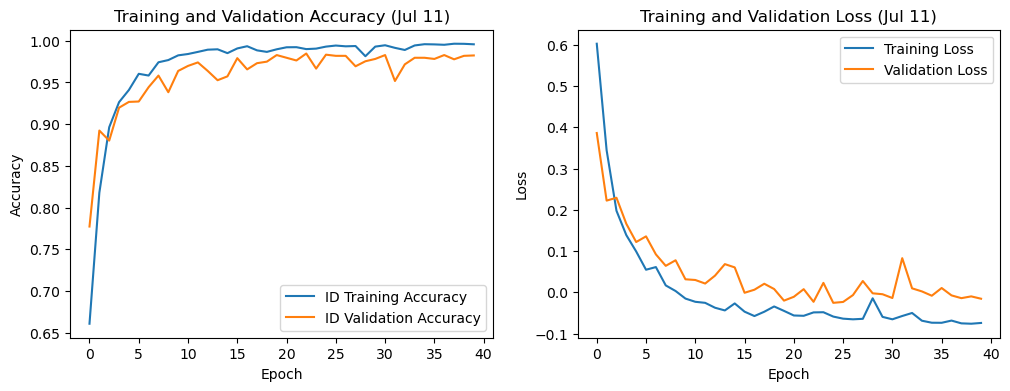

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_hist['id_accuracy'], label='ID Training Accuracy')
plt.plot(train_hist['val_id_accuracy'], label='ID Validation Accuracy')
plt.title('Training and Validation Accuracy (Jul 11)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_hist['loss'], label='Training Loss')
plt.plot(train_hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Jul 11)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Out-of-Distribution (OOD) Detection Training

## Mahalanobis Distance-Based OOD Detector

After training the main classifier, we now train a separate Out-of-Distribution detector using Mahalanobis distance in the feature space. This detector will help identify unknown signal types that don't belong to any of our known classes (16QAM, 8CPSK, FM).

**Key Concepts:**
- **Feature Space Analysis**: Uses learned representations from the penultimate layer
- **Class-Conditional Statistics**: Calculates mean and covariance for each known signal type
- **Mahalanobis Distance**: Measures statistical distance accounting for feature correlations
- **OOD Threshold**: Signals beyond threshold distance are classified as UNKNOWN

**Training Pipeline:**
1. Extract features from trained classifier
2. Calculate class-conditional means and covariances
3. Compute optimal threshold using validation data
4. Save OOD detector for deployment

In [36]:
from scipy import linalg
from sklearn.covariance import EmpiricalCovariance, LedoitWolf
import pickle
import json

class MahalanobisOODDetector:
    """
    Mahalanobis distance-based Out-of-Distribution detector for neural networks.
    
    Based on "A Simple Unified Framework for Detecting Out-of-Distribution Samples 
    and Adversarial Attacks" (Lee et al., 2018)
    """
    
    def __init__(self, use_tied_cov=True, cov_estimator='ledoit_wolf'):
        """
        Initialize Mahalanobis OOD detector.
        
        Args:
            use_tied_cov: If True, use pooled covariance across all classes
            cov_estimator: 'empirical' or 'ledoit_wolf' for covariance estimation
        """
        self.use_tied_cov = use_tied_cov
        self.cov_estimator = cov_estimator
        self.class_means = {}
        self.class_covs = {}
        self.pooled_cov = None
        self.inv_covs = {}
        self.fitted = False
        self.known_classes = None
        self.threshold = None
        
    def fit(self, features, labels, class_names, validation_features=None, validation_labels=None):
        """
        Fit the Mahalanobis detector using training features.
        
        Args:
            features: Training features from penultimate layer, shape (n_samples, n_features)
            labels: Training labels, shape (n_samples,)
            class_names: List of class names corresponding to label indices
            validation_features: Optional validation features for threshold calculation
            validation_labels: Optional validation labels for threshold calculation
        """
        print("=" * 60)
        print("FITTING MAHALANOBIS OOD DETECTOR")
        print("=" * 60)
        
        self.known_classes = class_names
        unique_labels = np.unique(labels)
        
        print(f"Known classes: {class_names}")
        print(f"Feature dimension: {features.shape[1]}")
        print(f"Total training samples: {features.shape[0]}")
        
        # Calculate class-conditional means
        print(f"\nCalculating class-conditional means...")
        for label in unique_labels:
            if label < len(class_names):  # Only process known classes
                class_mask = labels == label
                class_features = features[class_mask]
                self.class_means[label] = np.mean(class_features, axis=0)
                
                print(f"  {class_names[label]}: {class_features.shape[0]} samples")
        
        # Calculate covariance matrices
        print(f"\nCalculating covariance matrices...")
        if self.use_tied_cov:
            # Use pooled covariance across all known classes
            all_known_features = []
            
            for label in unique_labels:
                if label < len(class_names):  # Only known classes
                    class_mask = labels == label
                    class_features = features[class_mask]
                    all_known_features.append(class_features)
            
            all_known_features = np.vstack(all_known_features)
            
            # Estimate pooled covariance
            if self.cov_estimator == 'ledoit_wolf':
                print("  Using Ledoit-Wolf covariance estimation...")
                cov_estimator = LedoitWolf()
                cov_estimator.fit(all_known_features)
                self.pooled_cov = cov_estimator.covariance_
            else:
                print("  Using empirical covariance estimation...")
                self.pooled_cov = np.cov(all_known_features.T)
            
            # Use same covariance for all classes
            for label in unique_labels:
                if label < len(class_names):
                    self.class_covs[label] = self.pooled_cov
            
            print(f"  Tied covariance matrix shape: {self.pooled_cov.shape}")
            
        else:
            # Use class-specific covariances
            print("  Using class-specific covariances...")
            for label in unique_labels:
                if label < len(class_names):
                    class_mask = labels == label
                    class_features = features[class_mask]
                    
                    if self.cov_estimator == 'ledoit_wolf':
                        cov_estimator = LedoitWolf()
                        cov_estimator.fit(class_features)
                        self.class_covs[label] = cov_estimator.covariance_
                    else:
                        self.class_covs[label] = np.cov(class_features.T)
        
        # Compute inverse covariances for efficiency
        print(f"\nComputing inverse covariance matrices...")
        for label in self.class_covs:
            try:
                self.inv_covs[label] = linalg.inv(self.class_covs[label])
                print(f"  {class_names[label]}: Successfully inverted")
            except linalg.LinAlgError:
                # Use pseudo-inverse if matrix is singular
                self.inv_covs[label] = linalg.pinv(self.class_covs[label])
                print(f"  {class_names[label]}: Using pseudo-inverse (singular matrix)")
        
        # Calculate threshold using validation data if provided
        if validation_features is not None and validation_labels is not None:
            print(f"\nCalculating optimal threshold using validation data...")
            val_distances = self._compute_min_distances(validation_features)
            self.threshold = np.percentile(val_distances, 95)
            print(f"  Threshold (95th percentile): {self.threshold:.4f}")
        else:
            # Use training data for threshold calculation
            print(f"\nCalculating threshold using training data...")
            train_distances = self._compute_min_distances(features)
            self.threshold = np.percentile(train_distances, 95)
            print(f"  Threshold (95th percentile): {self.threshold:.4f}")
        
        self.fitted = True
        print(f"\n✅ Mahalanobis OOD detector fitted successfully!")
        
        return self
    
    def _compute_min_distances(self, features):
        """Compute minimum Mahalanobis distances across all classes"""
        if not self.fitted and len(self.class_means) == 0:
            raise ValueError("Detector must be fitted before computing distances")
        
        n_samples = features.shape[0]
        distances = {}
        
        # Compute Mahalanobis distance to each class
        for label in self.class_means:
            class_mean = self.class_means[label]
            inv_cov = self.inv_covs[label]
            
            # Center the features
            centered_features = features - class_mean
            
            # Compute Mahalanobis distance: sqrt((x-μ)^T Σ^(-1) (x-μ))
            mahal_dist = np.sqrt(np.sum(centered_features @ inv_cov * centered_features, axis=1))
            distances[label] = mahal_dist
        
        # Find minimum distance across all classes
        distance_matrix = np.stack(list(distances.values()), axis=1)
        min_distances = np.min(distance_matrix, axis=1)
        
        return min_distances
    
    def predict_ood(self, features, threshold=None):
        """
        Predict out-of-distribution samples.
        
        Args:
            features: Test features, shape (n_samples, n_features)
            threshold: Mahalanobis distance threshold. If None, uses fitted threshold
            
        Returns:
            ood_predictions: Boolean array, True for OOD samples
            min_distances: Minimum Mahalanobis distances
        """
        if not self.fitted:
            raise ValueError("Detector must be fitted before making predictions")
        
        min_distances = self._compute_min_distances(features)
        
        if threshold is None:
            threshold = self.threshold
        
        ood_predictions = min_distances > threshold
        
        return ood_predictions, min_distances
    
    def save(self, filepath):
        """Save the fitted detector to file"""
        detector_data = {
            'use_tied_cov': self.use_tied_cov,
            'cov_estimator': self.cov_estimator,
            'class_means': {int(k): v.tolist() for k, v in self.class_means.items()},
            'class_covs': {int(k): v.tolist() for k, v in self.class_covs.items()},
            'pooled_cov': self.pooled_cov.tolist() if self.pooled_cov is not None else None,
            'inv_covs': {int(k): v.tolist() for k, v in self.inv_covs.items()},
            'fitted': self.fitted,
            'known_classes': self.known_classes,
            'threshold': float(self.threshold) if self.threshold is not None else None
        }
        
        with open(filepath, 'w') as f:
            json.dump(detector_data, f, indent=2)
        
        print(f"✅ OOD detector saved to: {filepath}")

print("✅ Mahalanobis OOD detector class implemented!")

✅ Mahalanobis OOD detector class implemented!


In [19]:
train_labels

array([2, 0, 1, ..., 1, 0, 1], dtype=int64)

In [37]:
## Extract Features for OOD Detector Training

def extract_features_from_model(model, X_data, layer_name=None):
    """
    Extract features from a specific layer of the model.
    
    Args:
        model: Trained Keras model
        X_data: Input data
        layer_name: Name of layer to extract from. If None, uses penultimate layer
        
    Returns:
        features: Extracted features, shape (n_samples, n_features)
    """
    if layer_name is None:
        # Use penultimate layer (before final classification layer)
        feature_layer = model.layers[-4]
    else:
        feature_layer = model.get_layer(layer_name)
    
    print(f"Extracting features from layer: {feature_layer.name}")
    print(f"Layer output shape: {feature_layer.output_shape}")
    
    # Create feature extraction model
    feature_extractor = tf.keras.Model(
        inputs=model.input,
        outputs=feature_layer.output
    )

    print(f"\nFeature extractor layers:")
    for i, layer in enumerate(feature_extractor.layers):
        print(f"  {i}: {layer.name} - {type(layer).__name__}")
    
    # Extract features
    features = feature_extractor.predict(X_data, verbose=1)
    
    # Flatten if needed (for dense layers, features might be 2D)
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
    
    print(f"Extracted features shape: {features.shape}")
    return features

print("=" * 60)
print("EXTRACTING FEATURES FOR OOD DETECTOR TRAINING")
print("=" * 60)

# Extract features from the trained model using training data
print(f"\nExtracting features from training data...")
print(f"Training data shape: {X_train.shape}")

train_features = extract_features_from_model(model, X_train)
train_labels = np.argmax(y_train, axis=1)  # Convert from one-hot to class indices

print(f"\nFeature extraction completed:")
print(f"  Training features shape: {train_features.shape}")
print(f"  Training labels shape: {train_labels.shape}")

# Show class distribution
print(f"\nClass distribution in training data:")
for i, class_name in enumerate(list(signal_tags.keys())):
    count = np.sum(train_labels == i)
    print(f"  {class_name}: {count} samples")

print("✅ Feature extraction completed!")

EXTRACTING FEATURES FOR OOD DETECTOR TRAINING

Extracting features from training data...
Training data shape: (10820, 2, 1024, 1)
Extracting features from layer: flatten
Layer output shape: (None, 768)

Feature extractor layers:
  0: input_1 - InputLayer
  1: conv2d - Conv2D
  2: conv2d_1 - Conv2D
  3: conv2d_2 - Conv2D
  4: concatenate - Concatenate
  5: conv2d_3 - Conv2D
  6: conv2d_4 - Conv2D
  7: concatenate_1 - Concatenate
  8: max_pooling2d - MaxPooling2D
  9: conv2d_5 - Conv2D
  10: conv2d_6 - Conv2D
  11: conv2d_7 - Conv2D
  12: concatenate_2 - Concatenate
  13: conv2d_8 - Conv2D
  14: conv2d_9 - Conv2D
  15: concatenate_3 - Concatenate
  16: max_pooling2d_1 - MaxPooling2D
  17: conv2d_10 - Conv2D
  18: conv2d_11 - Conv2D
  19: conv2d_12 - Conv2D
  20: concatenate_4 - Concatenate
  21: conv2d_13 - Conv2D
  22: conv2d_14 - Conv2D
  23: concatenate_5 - Concatenate
  24: max_pooling2d_2 - MaxPooling2D
  25: conv2d_15 - Conv2D
  26: conv2d_16 - Conv2D
  27: conv2d_17 - Conv2D
  28:

In [38]:
## Split Data for OOD Detector Training

from sklearn.model_selection import train_test_split

# Split the training data for OOD detector training and validation
# Use 80% for fitting the detector, 20% for threshold calculation
print("=" * 60)
print("SPLITTING DATA FOR OOD DETECTOR TRAINING")
print("=" * 60)

# Ensure we have enough samples for each class
min_samples_per_class = min([np.sum(train_labels == i) for i in np.unique(train_labels)])
print(f"Minimum samples per class: {min_samples_per_class}")

if min_samples_per_class < 10:
    print("⚠️  Warning: Very few samples per class. Consider using all data for training.")
    # Use all data for training if we have very limited samples
    ood_train_features = train_features
    ood_train_labels = train_labels
    ood_val_features = None
    ood_val_labels = None
    print("Using all training data for OOD detector fitting.")
else:
    # Split data while preserving class distribution
    ood_train_features, ood_val_features, ood_train_labels, ood_val_labels = train_test_split(
        train_features, 
        train_labels,
        test_size=0.2,
        random_state=42,
        stratify=train_labels
    )
    
    print(f"OOD training features shape: {ood_train_features.shape}")
    print(f"OOD validation features shape: {ood_val_features.shape}")
    
    print(f"\nOOD training set class distribution:")
    for i, class_name in enumerate(list(signal_tags.keys())):
        count = np.sum(ood_train_labels == i)
        print(f"  {class_name}: {count} samples")
    
    print(f"\nOOD validation set class distribution:")
    for i, class_name in enumerate(list(signal_tags.keys())):
        count = np.sum(ood_val_labels == i)
        print(f"  {class_name}: {count} samples")

print("✅ Data splitting completed!")

SPLITTING DATA FOR OOD DETECTOR TRAINING
Minimum samples per class: 3470
OOD training features shape: (8656, 768)
OOD validation features shape: (2164, 768)

OOD training set class distribution:
  16QAM: 3048 samples
  8CPSK: 2832 samples
  FM: 2776 samples

OOD validation set class distribution:
  16QAM: 762 samples
  8CPSK: 708 samples
  FM: 694 samples
✅ Data splitting completed!


In [39]:
## Train Mahalanobis OOD Detector

# Initialize and train the OOD detector
print("=" * 60)
print("TRAINING MAHALANOBIS OOD DETECTOR")
print("=" * 60)

# Create class names list from signal_tags
class_names = list(signal_tags.keys())
print(f"Training OOD detector for classes: {class_names}")

# Initialize the detector
ood_detector = MahalanobisOODDetector(
    use_tied_cov=True,  # Use pooled covariance for robustness
    cov_estimator='ledoit_wolf'  # Use Ledoit-Wolf for better covariance estimation
)

# Train the detector
ood_detector.fit(
    features=ood_train_features,
    labels=ood_train_labels,
    class_names=class_names,
    validation_features=ood_val_features,
    validation_labels=ood_val_labels
)

print(f"\n{'='*60}")
print("OOD DETECTOR TRAINING SUMMARY")
print(f"{'='*60}")
print(f"✅ Detector fitted successfully!")
print(f"📊 Feature dimension: {ood_train_features.shape[1]}")
print(f"🎯 Number of known classes: {len(class_names)}")
print(f"📈 Threshold: {ood_detector.threshold:.4f}")
print(f"🔧 Covariance estimator: {ood_detector.cov_estimator}")
print(f"🔗 Tied covariance: {ood_detector.use_tied_cov}")

# Quick validation on training data
if ood_val_features is not None:
    print(f"\n{'='*60}")
    print("QUICK VALIDATION ON HELD-OUT DATA")
    print(f"{'='*60}")
    
    # Predict OOD on validation set (should be all known, so mostly False)
    val_ood_pred, val_distances = ood_detector.predict_ood(ood_val_features)
    
    print(f"Validation samples: {len(ood_val_features)}")
    print(f"Predicted as OOD: {np.sum(val_ood_pred)} ({np.mean(val_ood_pred)*100:.1f}%)")
    print(f"Mean distance: {np.mean(val_distances):.4f}")
    print(f"Distance std: {np.std(val_distances):.4f}")
    print(f"Distance range: [{np.min(val_distances):.4f}, {np.max(val_distances):.4f}]")
    
    # Show per-class statistics
    print(f"\nPer-class validation statistics:")
    for i, class_name in enumerate(class_names):
        class_mask = ood_val_labels == i
        if np.sum(class_mask) > 0:
            class_distances = val_distances[class_mask]
            class_ood_rate = np.mean(val_ood_pred[class_mask])
            print(f"  {class_name}: Mean dist={np.mean(class_distances):.4f}, OOD rate={class_ood_rate*100:.1f}%")

print(f"\n✅ OOD detector training completed!")

TRAINING MAHALANOBIS OOD DETECTOR
Training OOD detector for classes: ['16QAM', '8CPSK', 'FM']
FITTING MAHALANOBIS OOD DETECTOR
Known classes: ['16QAM', '8CPSK', 'FM']
Feature dimension: 768
Total training samples: 8656

Calculating class-conditional means...
  16QAM: 3048 samples
  8CPSK: 2832 samples
  FM: 2776 samples

Calculating covariance matrices...
  Using Ledoit-Wolf covariance estimation...
  Tied covariance matrix shape: (768, 768)

Computing inverse covariance matrices...
  16QAM: Successfully inverted
  8CPSK: Successfully inverted
  FM: Successfully inverted

Calculating optimal threshold using validation data...
  Threshold (95th percentile): 40.9944

✅ Mahalanobis OOD detector fitted successfully!

OOD DETECTOR TRAINING SUMMARY
✅ Detector fitted successfully!
📊 Feature dimension: 768
🎯 Number of known classes: 3
📈 Threshold: 40.9944
🔧 Covariance estimator: ledoit_wolf
🔗 Tied covariance: True

QUICK VALIDATION ON HELD-OUT DATA
Validation samples: 2164
Predicted as OOD: 10

In [35]:
for i in range(-1, -6, -1):
    print(f"Layer name: {model.layers[i].name}, Output shape: {model.layers[i].output_shape}")

Layer name: dense_2, Output shape: (None, 3)
Layer name: dense_1, Output shape: (None, 128)
Layer name: dense, Output shape: (None, 128)
Layer name: flatten, Output shape: (None, 768)
Layer name: max_pooling2d_5, Output shape: (None, 1, 16, 48)


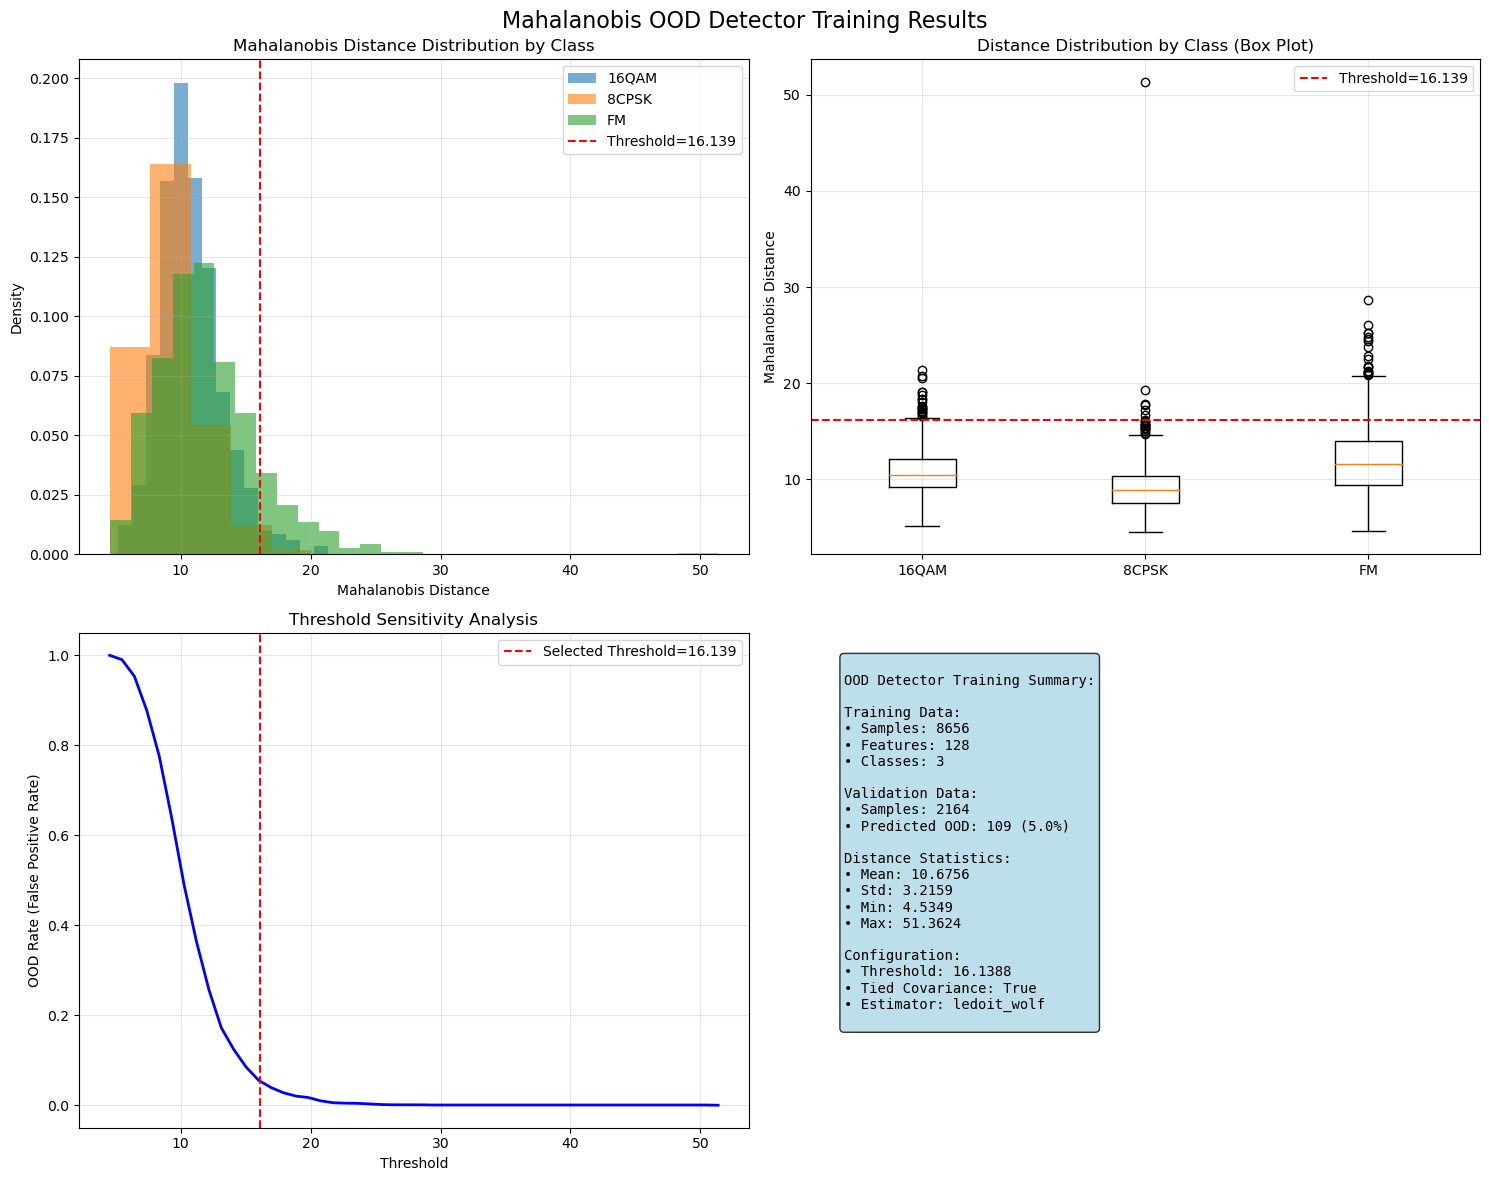

📊 OOD detector visualization completed!


In [24]:
## Visualize OOD Detector Training Results

if ood_val_features is not None:
    # Create visualizations of the OOD detector performance
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Mahalanobis OOD Detector Training Results', fontsize=16)
    
    # 1. Distance distribution by class
    axes[0, 0].set_title('Mahalanobis Distance Distribution by Class')
    
    for i, class_name in enumerate(class_names):
        class_mask = ood_val_labels == i
        if np.sum(class_mask) > 0:
            class_distances = val_distances[class_mask]
            axes[0, 0].hist(class_distances, bins=15, alpha=0.6, label=class_name, density=True)
    
    axes[0, 0].axvline(ood_detector.threshold, color='red', linestyle='--', 
                       label=f'Threshold={ood_detector.threshold:.3f}')
    axes[0, 0].set_xlabel('Mahalanobis Distance')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plot of distances by class
    axes[0, 1].set_title('Distance Distribution by Class (Box Plot)')
    
    class_distances_list = []
    class_labels_list = []
    
    for i, class_name in enumerate(class_names):
        class_mask = ood_val_labels == i
        if np.sum(class_mask) > 0:
            class_distances_list.append(val_distances[class_mask])
            class_labels_list.append(class_name)
    
    if class_distances_list:
        axes[0, 1].boxplot(class_distances_list, labels=class_labels_list)
        axes[0, 1].axhline(ood_detector.threshold, color='red', linestyle='--', 
                           label=f'Threshold={ood_detector.threshold:.3f}')
        axes[0, 1].set_ylabel('Mahalanobis Distance')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Threshold sensitivity analysis
    axes[1, 0].set_title('Threshold Sensitivity Analysis')
    
    # Test different thresholds
    thresholds = np.linspace(np.min(val_distances), np.max(val_distances), 50)
    ood_rates = []
    
    for thresh in thresholds:
        ood_pred_thresh = val_distances > thresh
        ood_rate = np.mean(ood_pred_thresh)
        ood_rates.append(ood_rate)
    
    axes[1, 0].plot(thresholds, ood_rates, 'b-', linewidth=2)
    axes[1, 0].axvline(ood_detector.threshold, color='red', linestyle='--', 
                       label=f'Selected Threshold={ood_detector.threshold:.3f}')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('OOD Rate (False Positive Rate)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Summary statistics
    axes[1, 1].axis('off')
    
    summary_text = f"""
OOD Detector Training Summary:

Training Data:
• Samples: {ood_train_features.shape[0]}
• Features: {ood_train_features.shape[1]}
• Classes: {len(class_names)}

Validation Data:
• Samples: {ood_val_features.shape[0]}
• Predicted OOD: {np.sum(val_ood_pred)} ({np.mean(val_ood_pred)*100:.1f}%)

Distance Statistics:
• Mean: {np.mean(val_distances):.4f}
• Std: {np.std(val_distances):.4f}
• Min: {np.min(val_distances):.4f}
• Max: {np.max(val_distances):.4f}

Configuration:
• Threshold: {ood_detector.threshold:.4f}
• Tied Covariance: {ood_detector.use_tied_cov}
• Estimator: {ood_detector.cov_estimator}
    """
    
    axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("📊 OOD detector visualization completed!")
else:
    print("📊 Skipping visualization (no validation data available)")
    
    # Simple histogram of training distances
    train_distances = ood_detector._compute_min_distances(ood_train_features)
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_distances, bins=30, alpha=0.7, density=True)
    plt.axvline(ood_detector.threshold, color='red', linestyle='--', 
                label=f'Threshold={ood_detector.threshold:.3f}')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.title('Training Data Distance Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        class_mask = ood_train_labels == i
        if np.sum(class_mask) > 0:
            class_distances = train_distances[class_mask]
            plt.hist(class_distances, bins=15, alpha=0.6, label=class_name, density=True)
    
    plt.axvline(ood_detector.threshold, color='red', linestyle='--', 
                label=f'Threshold={ood_detector.threshold:.3f}')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.title('Distance Distribution by Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [40]:
## Save OOD Detector and Training Metadata

import os
from datetime import datetime

# Create directory for OOD detectors if it doesn't exist
ood_detector_dir = 'C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors'
os.makedirs(ood_detector_dir, exist_ok=True)

# Generate filename with timestamp and model info
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = 'jul25_rms_1'  # Match the saved model name
ood_detector_filename = f"mahalanobis_ood_detector_{model_name}_{timestamp}_flatten_layer.json"
ood_detector_filepath = os.path.join(ood_detector_dir, ood_detector_filename)

print("=" * 60)
print("SAVING OOD DETECTOR AND METADATA")
print("=" * 60)

# Save the OOD detector
ood_detector.save(ood_detector_filepath)

# Create and save comprehensive training metadata
training_metadata = {
    "training_info": {
        "timestamp": datetime.now().isoformat(),
        "model_name": model_name,
        "model_path": f"C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/trained_models/{model_name}",
        "ood_detector_path": ood_detector_filepath,
        "training_duration": "Post-training (after main classifier)",
        "tensorflow_version": tf.__version__
    },
    
    "data_info": {
        "train_store_path": train_store_path,
        "total_training_samples": int(X_train.shape[0]),
        "ood_training_samples": int(ood_train_features.shape[0]),
        "ood_validation_samples": int(ood_val_features.shape[0]) if ood_val_features is not None else 0,
        "feature_dimension": int(ood_train_features.shape[1]),
        "record_length": rlength,
        "signal_classes": class_names,
        "class_distribution": {
            class_name: int(np.sum(ood_train_labels == i)) 
            for i, class_name in enumerate(class_names)
        }
    },
    
    "model_architecture": {
        "classifier_layers": len(model.layers),
        "feature_extraction_layer": model.layers[-4].name,
        "feature_layer_output_shape": str(model.layers[-4].output_shape),
        "total_parameters": int(model.count_params()),
        "optimizer": "Adam",
        "learning_rate": lr,
        "batch_size": batch_size,
        "epochs_trained": len(train_hist['loss'])
    },
    
    "ood_detector_config": {
        "detector_type": "Mahalanobis",
        "use_tied_covariance": ood_detector.use_tied_cov,
        "covariance_estimator": ood_detector.cov_estimator,
        "threshold": float(ood_detector.threshold),
        "threshold_method": "95th_percentile"
    },
    
    "training_results": {
        "final_train_accuracy": float(train_hist['accuracy'][-1]),
        "final_val_accuracy": float(train_hist['val_accuracy'][-1]),
        "final_train_loss": float(train_hist['loss'][-1]),
        "final_val_loss": float(train_hist['val_loss'][-1]),
        "ood_validation_stats": {
            "total_samples": int(len(ood_val_features)) if ood_val_features is not None else 0,
            "predicted_ood": int(np.sum(val_ood_pred)) if ood_val_features is not None else 0,
            "ood_rate": float(np.mean(val_ood_pred)) if ood_val_features is not None else 0.0,
            "mean_distance": float(np.mean(val_distances)) if ood_val_features is not None else 0.0,
            "distance_std": float(np.std(val_distances)) if ood_val_features is not None else 0.0
        }
    },
    
    "usage_instructions": {
        "loading": "Use json.load() to load detector parameters",
        "feature_extraction": f"Extract features from layer '{model.layers[-4].name}' of the trained classifier",
        "prediction": "Use extracted features with loaded detector for OOD detection",
        "threshold": "Distances above threshold indicate OOD samples"
    }
}

# Save training metadata
metadata_filename = f"ood_training_metadata_{model_name}_{timestamp}.json"
metadata_filepath = os.path.join(ood_detector_dir, metadata_filename)

with open(metadata_filepath, 'w') as f:
    json.dump(training_metadata, f, indent=2)

print(f"📁 Files saved:")
print(f"  • OOD Detector: {ood_detector_filepath}")
print(f"  • Training Metadata: {metadata_filepath}")

print(f"\n📋 Training Summary:")
print(f"  • Model: {model_name}")
print(f"  • Training samples: {X_train.shape[0]}")
print(f"  • Feature dimension: {ood_train_features.shape[1]}")
print(f"  • Known classes: {len(class_names)}")
print(f"  • OOD threshold: {ood_detector.threshold:.4f}")
print(f"  • Final accuracy: {train_hist['accuracy'][-1]:.4f}")

print(f"\n🚀 Deployment Ready:")
print(f"  1. Load classifier model: tf.keras.models.load_model('{model_name}')")
print(f"  2. Load OOD detector: json.load('{ood_detector_filename}')")
print(f"  3. Extract features from penultimate layer")
print(f"  4. Apply Mahalanobis distance for OOD detection")

print(f"\n✅ OOD detector training and saving completed successfully!")

SAVING OOD DETECTOR AND METADATA
✅ OOD detector saved to: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors\mahalanobis_ood_detector_jul25_rms_1_20250726_193658_flatten_layer.json
📁 Files saved:
  • OOD Detector: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors\mahalanobis_ood_detector_jul25_rms_1_20250726_193658_flatten_layer.json
  • Training Metadata: C:/Users/UserAdmin/Desktop/Jason - Signal Classification/AI Models/ood_detectors\ood_training_metadata_jul25_rms_1_20250726_193658.json

📋 Training Summary:
  • Model: jul25_rms_1
  • Training samples: 10820
  • Feature dimension: 768
  • Known classes: 3
  • OOD threshold: 40.9944
  • Final accuracy: 0.9949

🚀 Deployment Ready:
  1. Load classifier model: tf.keras.models.load_model('jul25_rms_1')
  2. Load OOD detector: json.load('mahalanobis_ood_detector_jul25_rms_1_20250726_193658_flatten_layer.json')
  3. Extract features from penultimate layer
  4. Apply Mahalanobis di